In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import *
from matplotlib import pyplot as plt
from random import random
from IPython.display import clear_output
%matplotlib inline

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx > 0 and batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
       train=True,
       download=True,
       transform=transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,))
       ])
    ),
    batch_size=64,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
        train=False,
        transform=transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=1000,
    shuffle=True)

model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
device = torch.device("cpu") # or 'gpu'
losses = []
accuracies = []
for epoch in range(0, 10):
    losses.extend(train(model, device, train_loader, optimizer, epoch))
    accuracies.append(test(model, device, train_loader))

/Users/jancetherapper/opt/anaconda3/envs/cs7643-final-project-cpu/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-2et07ktc/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [6400/60000	(11%)]	Loss: 0.617095
Train Epoch: 0 [12800/60000	(21%)]	Loss: 0.269205
Train Epoch: 0 [19200/60000	(32%)]	Loss: 0.395639
Train Epoch: 0 [25600/60000	(43%)]	Loss: 0.183154
Train Epoch: 0 [32000/60000	(53%)]	Loss: 0.187780
Train Epoch: 0 [38400/60000	(64%)]	Loss: 0.184705
Train Epoch: 0 [44800/60000	(75%)]	Loss: 0.078671
Train Epoch: 0 [51200/60000	(85%)]	Loss: 0.087679
Train Epoch: 0 [57600/60000	(96%)]	Loss: 0.041642

Average loss: 0.0982, Accuracy: 58252/60000 (97%)

Train Epoch: 1 [6400/60000	(11%)]	Loss: 0.055170
Train Epoch: 1 [12800/60000	(21%)]	Loss: 0.049245
Train Epoch: 1 [19200/60000	(32%)]	Loss: 0.184515
Train Epoch: 1 [25600/60000	(43%)]	Loss: 0.036643
Train Epoch: 1 [32000/60000	(53%)]	Loss: 0.038106
Train Epoch: 1 [38400/60000	(64%)]	Loss: 0.219233
Train Epoch: 1 [44800/60000	(75%)]	Loss: 0.148970
Train Epoch: 1 [51200/60000	(85%)]	Loss: 0.053254
Train Epoch: 1 [57600/60000	(96%)]	Loss: 0.022453

Average loss: 0.0624, Accuracy: 58866/60000 (98%)

In [ ]:
import team36
from team36.mnist.vgg import VGG
from team36.training import train, validate
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = '.'
DATA_DIR = f'{DIR}/data'
NAME = 'mnist'

training_set = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, 
                                          transform=transforms.ToTensor())

training_indices, validation_indices, _, _ = train_test_split(
    range(len(training_set)),
    training_set.targets,
    stratify=training_set.targets,
    test_size=0.1,
)
training_split = torch.utils.data.Subset(training_set, training_indices)
validation_split = torch.utils.data.Subset(training_set, validation_indices)

print(f"{len(training_split)} in training set")
print(f"{len(validation_split)} in validation set")

learning_rate = 1e-3
momentum = 5e-1
weight_decay = 5e-2
batch_size = 128
epochs = 10

sampler = torch.utils.data.RandomSampler(training_split, replacement=True, num_samples=1000)
training_loader = torch.utils.data.DataLoader(training_split, batch_size=batch_size, sampler=sampler)
test_loader = torch.utils.data.DataLoader(validation_split, batch_size=100, shuffle=False, num_workers=2)


model = VGG()
if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum, weight_decay=weight_decay)

best = 0.0
best_cm = None
best_model = None
train_accuracy_history = []
train_loss_history = []
accuracies = []
losses = []
for epoch in range(epochs):
    train_acc, train_loss = train(epoch, training_loader, model, optimizer, criterion)
    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    acc, cm, loss = validate(epoch, test_loader, model, criterion)
    accuracies.append(acc)
    losses.append(loss)
    
    print("Epoch {0} | Training accuracy: {1}% | Validation accuracy: {2}%".format(epoch, train_acc, acc))
    
    if acc > best:
        best = acc
        best_cm = cm
        best_model = copy.deepcopy(model)
        
training_curve, = plt.plot(train_accuracy_history, label='training')
validation_curve, = plt.plot(accuracies, label='validation')
plt.title('Accuracy Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

training_curve, = plt.plot(train_loss_history, label='training')
validation_curve, = plt.plot(losses, label='validation')
plt.title('Loss Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Best Validation Acccuracy: {:.4f}'.format(best))

54000 in training set
6000 in validation set
Epoch: [0][0/8]	Loss 2.5095 (2.5095)	Prec @1 0.0859 (0.0859)	
Epoch 0 | Training accuracy: 0.35499998927116394% | Validation accuracy: 0.6901666522026062%
Epoch: [1][0/8]	Loss 1.2223 (1.2223)	Prec @1 0.7266 (0.7266)	
Epoch 1 | Training accuracy: 0.7770000100135803% | Validation accuracy: 0.8143333196640015%
Epoch: [2][0/8]	Loss 0.8150 (0.8150)	Prec @1 0.8672 (0.8672)	
Epoch 2 | Training accuracy: 0.8460000157356262% | Validation accuracy: 0.8690000176429749%
Epoch: [3][0/8]	Loss 0.6257 (0.6257)	Prec @1 0.8594 (0.8594)	
Epoch 3 | Training accuracy: 0.8650000095367432% | Validation accuracy: 0.8920000195503235%
Epoch: [4][0/8]	Loss 0.4995 (0.4995)	Prec @1 0.9062 (0.9062)	
Epoch 4 | Training accuracy: 0.8970000147819519% | Validation accuracy: 0.9021666646003723%
Epoch: [5][0/8]	Loss 0.4293 (0.4293)	Prec @1 0.9453 (0.9453)	


In [ ]:
import team36
from team36.mnist.vgg import VGG
from team36.training import train, validate
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = '.'
DATA_DIR = f'{DIR}/data'
NAME = 'cifar10'

training_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, 
                                            transform=transforms.ToTensor())

training_indices, validation_indices, _, _ = train_test_split(
    range(len(training_set)),
    training_set.targets,
    stratify=training_set.targets,
    test_size=0.1,
)
training_split = torch.utils.data.Subset(training_set, training_indices)
validation_split = torch.utils.data.Subset(training_set, validation_indices)

print(f"{len(training_split)} in training set")
print(f"{len(validation_split)} in validation set")

learning_rate = 1e-3
momentum = 5e-1
weight_decay = 5e-2
batch_size = 128
epochs = 10

sampler = torch.utils.data.RandomSampler(training_split, replacement=True, num_samples=1000)
training_loader = torch.utils.data.DataLoader(training_split, batch_size=batch_size, sampler=sampler)
test_loader = torch.utils.data.DataLoader(validation_split, batch_size=100, shuffle=False, num_workers=2)

model = VGG(image_size=32, in_channels=3)
if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum, weight_decay=weight_decay)

best = 0.0
best_cm = None
best_model = None
train_accuracy_history = []
train_loss_history = []
accuracies = []
losses = []
for epoch in range(epochs):
    train_acc, train_loss = train(epoch, training_loader, model, optimizer, criterion)
    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    acc, cm, loss = validate(epoch, test_loader, model, criterion)
    accuracies.append(acc)
    losses.append(loss)
    
    print("Epoch {0} | Training accuracy: {1}% | Validation accuracy: {2}%".format(epoch, train_acc, acc))
    
    if acc > best:
        best = acc
        best_cm = cm
        best_model = copy.deepcopy(model)
        
training_curve, = plt.plot(train_accuracy_history, label='training')
validation_curve, = plt.plot(accuracies, label='validation')
plt.title('Accuracy Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

training_curve, = plt.plot(train_loss_history, label='training')
validation_curve, = plt.plot(losses, label='validation')
plt.title('Loss Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Best Validation Acccuracy: {:.4f}'.format(best))

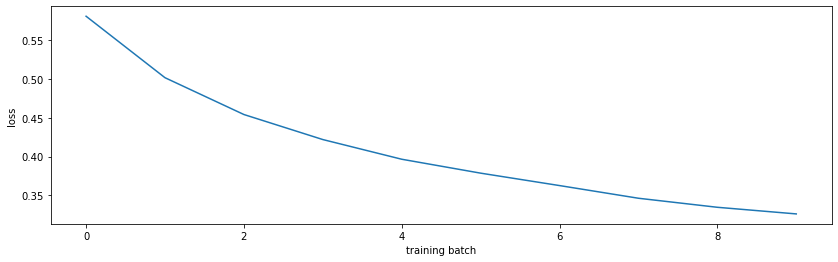

In [37]:
def mean(li): return sum(li)/len(li)
plt.figure(figsize=(14, 4))
plt.xlabel('training batch')
plt.ylabel('loss')
plt.plot([mean(losses[i:i+10]) for i in range(len(losses))])

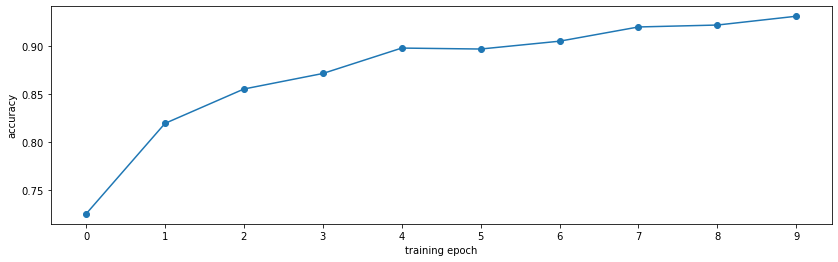

In [38]:

plt.figure(figsize=(14, 4))
plt.xticks(range(len(accuracies)))
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.plot(accuracies, marker='o')


In [39]:
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, test_loader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[576   1   1   2   2   3   4   1   1   1]
 [  0 650   9   1   3   3   1   1   5   1]
 [  3   3 558   1   8   1   8   8   6   0]
 [  1   5  24 542   0  14   1   9   8   9]
 [  0   2   3   0 553   1   4   0   0  21]
 [  1   3   2  19   1 495  13   1   2   5]
 [  4   4   3   0   2   7 570   0   2   0]
 [  1   6  10   1  12   1   0 580   0  16]
 [  2   3   6  10   3  11   7   3 524  16]
 [  5   1   6   6  13   3   0  17   2 542]]
F1 score: 0.931667
Accuracy score: 0.931667


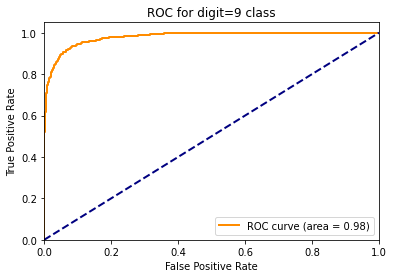

In [40]:

def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = 9
actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [41]:
print('Trainable parameters:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, '\t',param.numel())

Trainable parameters:
convolution_layers.0.weight 	 288
convolution_layers.0.bias 	 32
convolution_layers.1.weight 	 32
convolution_layers.1.bias 	 32
convolution_layers.3.weight 	 18432
convolution_layers.3.bias 	 64
convolution_layers.4.weight 	 64
convolution_layers.4.bias 	 64
convolution_layers.7.weight 	 73728
convolution_layers.7.bias 	 128
convolution_layers.8.weight 	 128
convolution_layers.8.bias 	 128
convolution_layers.10.weight 	 294912
convolution_layers.10.bias 	 256
convolution_layers.11.weight 	 256
convolution_layers.11.bias 	 256
linear_layers.0.weight 	 125440
linear_layers.0.bias 	 10


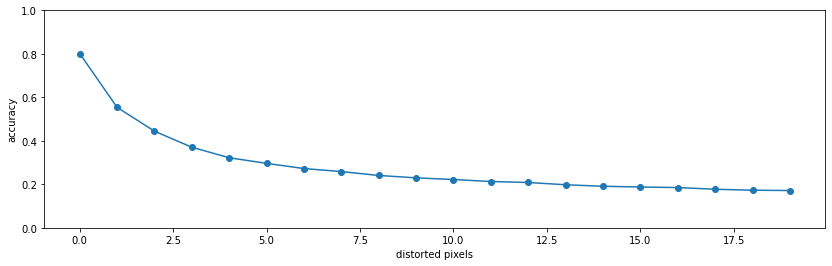

[0.8013, 0.5539, 0.4443, 0.3705, 0.3222, 0.2963, 0.2725, 0.2586, 0.2407, 0.2297, 0.2221, 0.2128, 0.2084, 0.1979, 0.191, 0.1877, 0.185, 0.1773, 0.1728, 0.1714]


In [42]:

def distort(x, num_pixels=1, value=1.0):
    for _ in range(num_pixels):
        x[0][int(random()*28)][int(random()*28)] = value
    return x

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

def plot_accuracies(distorted_pixels, accuracies):
    clear_output()
    plt.figure(figsize=(14, 4))
    plt.xlabel('distorted pixels')
    plt.ylabel('accuracy')
    plt.ylim((0, 1))
    plt.plot(distorted_pixels, accuracies, marker='o')
    plt.show()

distorted_pixels = []
accuracies = []
for i in range(0, 20):
    my_test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            '../data',
            train=False,
            transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Lambda(lambda x: distort(x, num_pixels=i, value=5.0)),
               transforms.Normalize((0.1307,), (0.3081,)),
            ])
        ),
        batch_size=1000,
        shuffle=True)
    actuals, predictions = test_label_predictions(model, device, my_test_loader)
    distorted_pixels.append(i)
    accuracies.append(accuracy_score(actuals, predictions))
    plot_accuracies(distorted_pixels, accuracies)

print(accuracies)

In [43]:
def set_pixel(x, i, j, value=1.0):
    x[0][i][j] = value
    return x

def misclassified_images(actuals, predictions):
    vuls = []
    for i in range(len(actuals)):
        if actuals[i] != predictions[i]:
            vuls.append(i)
    return set(vuls)


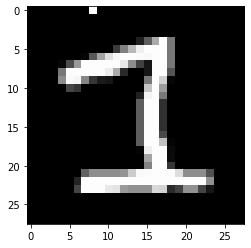

In [44]:

dataset = datasets.MNIST(
    '../data',
    train=False,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Lambda(lambda x: set_pixel(x, 0, 8)),
    ])
)
x, _ = dataset[3906] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

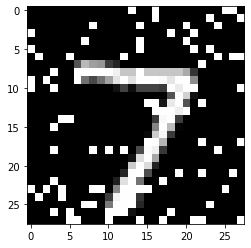

In [49]:
dataset = datasets.MNIST(
    '../data',
    train=False,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Lambda(lambda x: distort(x, num_pixels=100)),
    ])
)
x, _ = dataset[0] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')